In [1]:
from a_mps import *
from b_model import *
from c_tebd import *
from tfi_exact import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

**Exercise 11.1**

**(b)**

In [2]:
def imaginary_iTEBD(L, J, g):
    print("infinite TEBD, (imaginary time evolution)")
    print("L={L:d}, J={J:.1f}, g={g:.2f}".format(L=L, J=J, g=g))
    model = iTFIModel(L, J, g)
    psi = init_spinup_iMPS(L)
    for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:
        U_bonds = calc_U_bonds(model, dt)
        run_iTEBD(psi, U_bonds, N_steps=500, chi_max=30, eps=1.e-10)
        E = model.energy(psi)
        print("dt = {dt:.5f}: E = {E:.13f}".format(dt=dt, E=E))
    print("final bond dimensions: ", psi.get_chi())
    if L < 20:  # for small systems compare to exact diagonalization
        E_exact = infinite_gs_energy(J, g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, model

In [3]:
E, psi, model = imaginary_iTEBD(L=2, J=1, g=1)

infinite TEBD, (imaginary time evolution)
L=2, J=1.0, g=1.00
dt = 0.10000: E = -1.2689318050868
dt = 0.01000: E = -1.2728170781934
dt = 0.00100: E = -1.2731936013346
dt = 0.00010: E = -1.2732311735223
dt = 0.00001: E = -1.2732349328054
final bond dimensions:  [30, 30]
Exact diagonalization: E = -1.2732395447352
relative error:  3.6222011458533383e-06


**(c)**

In [4]:
def transfermatrix(mps):

    assert mps.L == 2

    T = np.tensordot(mps.Bs[0], mps.Bs[1], axes=[2, 0]) # v0L i0 [v0R], [v1L] i1 v1R
    T = np.tensordot(T, T.conj(), axes=[[1, 2], [1, 2]]) # v0L [i0] [i1] v1R, v0L' [i0'] [i1'] v1R'
    T = T.transpose([0, 2, 1, 3]) # v0L v0L' v1R v1R'
    T = T.reshape(T.shape[0]*T.shape[1], T.shape[2]*T.shape[3]) # v0L*v0L' v1R*v1R'

    return T

**(d)**

In [5]:
def imaginary_iTEBD(L, J, g):

    model = iTFIModel(L, J=J, g=g)
    psi = init_spinup_iMPS(L)
    for dt in [0.1, 0.01, 0.001, 1.e-4, 1.e-5]:

        U_bonds = calc_U_bonds(model, dt)
        run_iTEBD(psi, U_bonds, N_steps=500, chi_max=30, eps=1.e-10)
        E = model.energy(psi)

    return E, psi, model

In [6]:
L=2
J=1
g_list = np.arange(0.5, 1.5 + 0.1, 0.1)
max = 5

Λ = np.zeros((max, len(g_list)))
for i, g in enumerate(g_list):

    _, psi, _ = imaginary_iTEBD(L, J, g)
    λs, _ = sp.sparse.linalg.eigs(transfermatrix(psi), max, which='LM')
    Λ[:, i] = np.abs(λs)

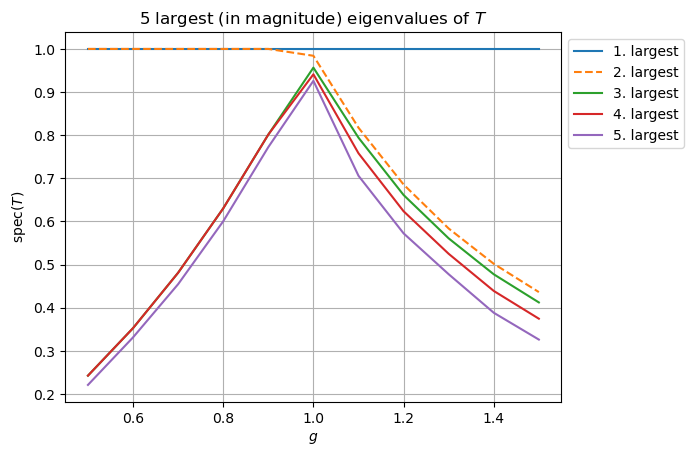

In [8]:
fig, ax = plt.subplots(1, 1)
for k in range(max):
    ax.plot(g_list, Λ[k, :], '--' if k==1 else '-', label='%d. largest'%(k+1))
ax.set_xlabel('$g$'), ax.set_ylabel('spec($T$)'), ax.set_title('%d largest (in magnitude) eigenvalues of $T$'%(max)), ax.grid(), ax.legend(bbox_to_anchor=(1.0, 1.0));

The eigenvalues of the tranfermatrix $T$ are smaller or equal to 1 (in magnitude). In the thermodynamic limit $N\to\infty$, all eigenvalues of $T$ converge to zero except the eigenvalue 1. From the above plot we infer that, while the eigenstate to 1 is unique for $g>1$, this eigenspace becomes two-dimensional at the phase transition, since the 2nd largest eigenvalue is also 1 for $g<1$. This means that the transition of the ground state at $g>1$, $\ket{00...}$, to the ground state at $g<1$, the equal superposition of $\ket{\rightarrow\rightarrow ... }$ and $\ket{\leftarrow\leftarrow ... }$, is instantaneous. In contrast, at a finite system size $N$, these ground states are only obtained in the limits $g\to\infty$ and $g=0$, respectively, and the phase transition happens more smoothely in a sense that we have quantum fluctuations on top, originating from eigenspaces of the all the other eigenvalues. These fluctuations are maximal at the phase transition $g=1$.

**Exercise 11.2**

In [9]:
from e_tps import *

**(a)**

In [10]:
example_run_ising_honeycomb()

Parameters:  {'chi_tps': 2, 'chi_mps': 20, 'J': 1.0, 'g': 1.0, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values


array([-1.66909168])

**(b)**

In [11]:
def init_M_bonds(model):
    s0, sx, sz = model.id, model.sigmax, model.sigmaz
    d = 2

    Mx_bonds, Mz_bonds = list(), list()
    for i in range(model.z):
        Mx, Mz = np.kron(sx, sx), np.kron(sz, sz)
        Mx_bonds.append(np.reshape(Mx, (d, d, d, d))), Mz_bonds.append(np.reshape(Mz, (d, d, d, d)))

    return Mx_bonds, Mz_bonds

In [12]:
def run_ising_honeycomb_and_measure_magnetization(chi_tps=2, chi_mps=20, J=1., g=1., N_imaginary=300, N_boundary=10):
    print("Parameters: ", locals())
    model = TFIModelHoneycomb(J, g)
    psi_tps = run_simplified_update(model, chi_tps, N_imaginary)
    print("evaluating expectation values")
    Mx_bonds, Mz_bonds = init_M_bonds(model)
    exp_vals_mx = evaluate_exp_vals(psi_tps, [Mx_bonds], chi_mps, N_boundary)
    exp_vals_mz = evaluate_exp_vals(psi_tps, [Mz_bonds], chi_mps, N_boundary)
    return exp_vals_mx, exp_vals_mz

**(c)**

In [13]:
chi_mps_list = [2, 3, 4, 5]
chi_tps_list = [2, 3, 4, 6, 7, 8]

mx_dict, mz_dict =  dict(), dict()
for chi_mps in chi_mps_list:

    mx_dict[chi_mps], mz_dict[chi_mps] = list(), list()
    for chi_tps in chi_tps_list:

        mx, mz = run_ising_honeycomb_and_measure_magnetization(chi_tps, chi_mps)
        mx_dict[chi_mps].append(mx), mz_dict[chi_mps].append(mz)

Parameters:  {'chi_tps': 2, 'chi_mps': 2, 'J': 1.0, 'g': 1.0, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 3, 'chi_mps': 2, 'J': 1.0, 'g': 1.0, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 4, 'chi_mps': 2, 'J': 1.0, 'g': 1.0, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 6, 'chi_mps': 2, 'J': 1.0, 'g': 1.0, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 7, 'chi_mps': 2, 'J': 1.0, 'g': 1.0, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001


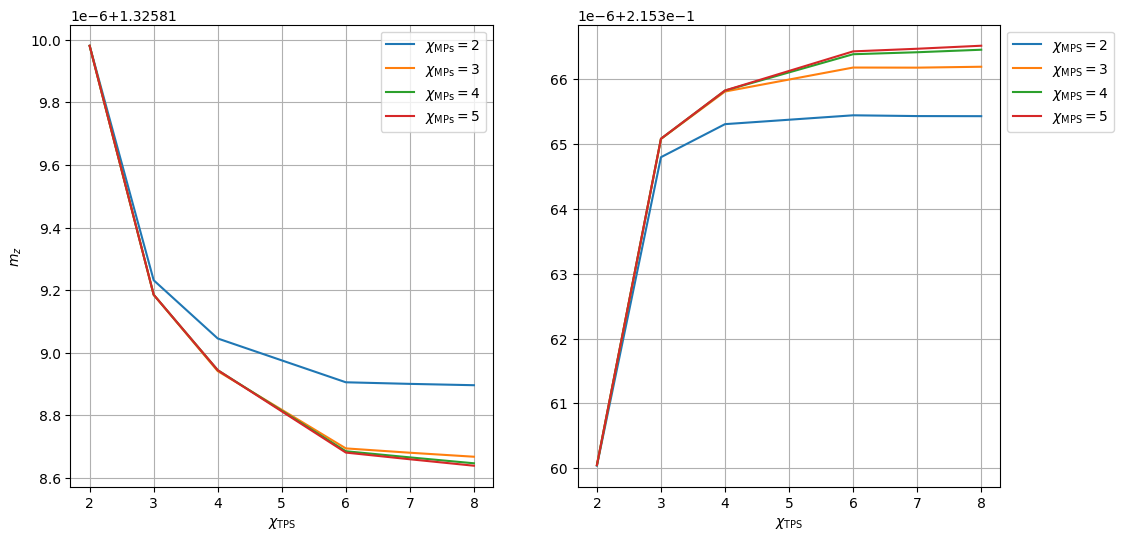

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
for i, chi_mps in enumerate(chi_mps_list):

    ax0.plot(chi_tps_list, mx_dict[chi_mps], label='$\chi_{\mathrm{MPs}} = %d$'%(chi_mps))
    ax1.plot(chi_tps_list, mz_dict[chi_mps], label='$\chi_{\mathrm{MPS}} = %d$'%(chi_mps))

ax0.set_xlabel('$\chi_{\mathrm{TPS}}$'), ax0.set_ylabel('$m_{x}$'), ax0.grid(), ax0.legend(bbox_to_anchor=(1.0, 1.0))
ax1.set_xlabel('$\chi_{\mathrm{TPS}}$'), ax0.set_ylabel('$m_{z}$'), ax1.grid(); ax1.legend(bbox_to_anchor=(1.0, 1.0));

In [28]:
chi_mps = 4
chi_tps = 8
gc = 2.13250
g_list = [1, 1.5, 2, 2.5, 3]
mx_list, mz_list = list(), list()
for g in g_list:
    mx, mz = run_ising_honeycomb_and_measure_magnetization(chi_tps, chi_mps, g=g)
    mx_list.append(mx), mz_list.append(mz)

Parameters:  {'chi_tps': 8, 'chi_mps': 4, 'J': 1.0, 'g': 1, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 8, 'chi_mps': 4, 'J': 1.0, 'g': 1.5, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 8, 'chi_mps': 4, 'J': 1.0, 'g': 2, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 8, 'chi_mps': 4, 'J': 1.0, 'g': 2.5, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evaluating expectation values
Parameters:  {'chi_tps': 8, 'chi_mps': 4, 'J': 1.0, 'g': 3, 'N_imaginary': 300, 'N_boundary': 10}
imaginary time evolution
--> delta = 0.1
--> delta = 0.01
--> delta = 0.001
evalua

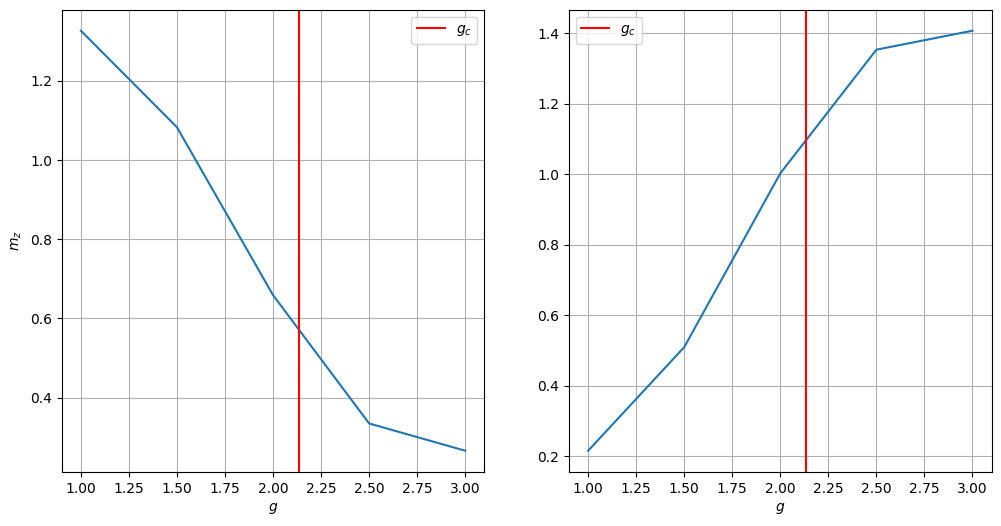

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(g_list, mx_list)
ax1.plot(g_list, mz_list)
ax0.axvline(x=gc, label='$g_{c}$', color='r')
ax1.axvline(x=gc, label='$g_{c}$', color='r')

ax0.set_xlabel('$g$'), ax0.set_ylabel('$m_{x}$'), ax0.grid(), ax0.legend()
ax1.set_xlabel('$g$'), ax0.set_ylabel('$m_{z}$'), ax1.grid(), ax1.legend();